**Importing Libraries**

In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict


**Define Map Class to Handle .tsp Files**

In [2]:
class Map:
    def __init__(self, towns: np.ndarray):
        self.towns = towns

    @staticmethod
    def from_tsp_file(file_path: str):
        towns = []
        
        with open(file_path, 'r') as f:
            lines = f.readlines()
            
            for line in lines:
                # Skip lines that are empty or contain invalid data
                if line.strip() == '' or line.startswith('EOF'):
                    continue
                
                # Only process lines that have numeric data (ignoring text lines)
                parts = line.split()
                if len(parts) < 3:
                    continue
                
                try:
                    # Parse the town coordinates (skipping the first element if it's an identifier)
                    town = list(map(float, parts[1:3]))  # Assuming the first column is an ID, and 2nd/3rd columns are coordinates
                    towns.append(town)
                except ValueError as e:
                    print(f"Skipping invalid line: {line.strip()}")
        
        return Map(np.array(towns))


    
    def get_towns_count(self):
        return len(self.towns)
    
    def as_numpy_array(self):
        return self.towns
    
    def visualize(self, solution=None):
        if solution is None:
            solution = np.arange(len(self.towns))
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.towns[solution, 0], self.towns[solution, 1], marker='o', color='r')
        plt.plot([self.towns[solution[-1], 0], self.towns[solution[0], 0]], 
                 [self.towns[solution[-1], 1], self.towns[solution[0], 1]], 
                 marker='o', color='r')
        plt.title("TSP Solution Path")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.grid(True)
        plt.show()


**Function to Load Files from Folder**

In [3]:
import os

def load_files_from_folder(folder_path: str):
    tsp_files = []
    problems_file = None
    
    # List all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check for .tsp files
        if filename.endswith(".tsp"):
            tsp_files.append(file_path)
        
        # Check for .problems file
        elif filename.endswith(".problems"):
            problems_file = file_path
    
    # Ensure at least one .tsp file and one .problems file is present
    if not tsp_files or not problems_file:
        raise ValueError("Folder must contain both .tsp files and a .problems file.")
    
    return tsp_files, problems_file


**Function to load problem data from .problem file**

In [4]:
def load_problems_data(problems_file: str):
    problem_data = {}
    
    with open(problems_file, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # Skip lines that don't contain an '='
            if '=' not in line:
                print(f"Skipping invalid line: {line}")
                continue
            
            # Split the line into key and value
            try:
                key, value = line.split('=', 1)  # Only split on the first '='
                problem_data[key.strip()] = value.strip()  # Remove any extra spaces
            except ValueError:
                print(f"Skipping line with invalid format: {line}")
    
    return problem_data


**Implementing the Genetic Algorithm Solver**

In [5]:
class TravelingSalesmanProblemSolver:
    def __init__(self, map_: Map, generation_size: int = 100, mutate_p: float = 0.05, n_iter: int = 50) -> None:
        self.map = map_
        self.generation_size = generation_size
        self.mutate_p = mutate_p
        self.n_iter = n_iter
    
    def spawn(self) -> np.ndarray:
        m = self.map.get_towns_count()
        n = self.generation_size
        population = []
        possible_values = np.int32(np.arange(m))

        for _ in range(n):
            individual = np.random.permutation(possible_values)
            population.append(individual)
        return np.vstack(population)
    
    def evaluate(self, population: np.ndarray) -> np.ndarray:
        map_ = self.map.as_numpy_array()
        scores = []
        for individual in population:
            distance = 0
            # Calculate the total distance for the current individual tour
            for i in range(len(individual) - 1):
                town1 = map_[individual[i]]
                town2 = map_[individual[i + 1]]
                distance += np.sqrt(np.sum(np.power(town1 - town2, 2)))  # Euclidean distance
            # Add the distance to return to the starting town
            town1 = map_[individual[-1]]
            town2 = map_[individual[0]]
            distance += np.sqrt(np.sum(np.power(town1 - town2, 2)))
            scores.append(distance)
        return np.array(scores)

    
    def select(self, population: np.ndarray, p: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        indices = np.arange(population.shape[0])
        p1, p2 = np.random.choice(indices, size=2, p=p)
        return population[p1], population[p2]
    
    def crossover(self, p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        indices = np.arange(start=1, stop=p1.shape[0] - 1)
        split_idx1 = np.random.choice(indices, size=1)
        split_idx2 = np.random.choice(indices, size=1)

        head1, _ = np.split(p1, indices_or_sections=split_idx1)
        head2, _ = np.split(p2, indices_or_sections=split_idx2)

        child1 = np.concatenate([head1, p2[~np.isin(p2, head1)]])
        child2 = np.concatenate([head2, p1[~np.isin(p1, head2)]])
        return child1, child2
    
    def mutate(self, individual: np.ndarray) -> np.ndarray:
        if np.random.rand() <= self.mutate_p:
            individual = np.roll(individual, shift=1)
        return individual
    
    def step(self, generation: np.ndarray, scores: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        n = self.generation_size
        new_generation = []
        p = 1 / scores
        p = p / np.sum(p)
        
        for _ in range(int(n / 2)):
            p1, p2 = self.select(generation, p)
            c1, c2 = self.crossover(p1, p2)
            c1 = self.mutate(c1)
            c2 = self.mutate(c2)
            new_generation.extend([c1, c2])

        new_generation = np.vstack(new_generation)
        new_scores = self.evaluate(new_generation)

        all_scores = np.concatenate([scores, new_scores])
        population = np.concatenate([generation, new_generation])
        top = np.argsort(all_scores)[:n]

        return population[top], all_scores[top]
    
    def train(self) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        generation = self.spawn()
        scores = self.evaluate(generation)

        means = []
        bests = []

        for _ in range(self.n_iter):
            means.append(scores.mean())
            bests.append(scores.min())
            generation, scores = self.step(generation, scores)

        means = np.array(means)
        bests = np.array(bests)

        solution = generation[scores.argmin()]
        return means, bests, solution


**Performance Evaluation and Visualization**

In [6]:
import time
import seaborn as sns

def evaluate_performance(solver):
    start_time = time.time()  # Start the timer

    means, bests, solution = solver.train()  # Run the solver

    execution_time = time.time() - start_time  # Get the execution time
    
    # Plot results
    ax = sns.lineplot(x=range(solver.n_iter), y=means)
    sns.lineplot(x=range(solver.n_iter), y=bests, ax=ax)
    
    return means, bests, solution, execution_time


**Main Execution**

Skipping invalid line: **********
Skipping invalid line: read.me
Skipping invalid line: **********
Skipping invalid line: This disk contains 4 files, containing information on the x-ray crystallography
Skipping invalid line: travelling salesman problem. A small amount of initial problem data is
Skipping invalid line: converted to coordinates for each node.1 Costs on edges are computed from these
Skipping invalid line: coordinates.
Skipping invalid line: READ.ME   this file
Skipping invalid line: DAUX.FOR  three routines:
Skipping invalid line: 1) setpts: converts crystal parameters to a list of angle data,
Skipping invalid line: calling "angles"
Skipping invalid line: 2) tcost: just computes cost of a tour stored in a particular
Skipping invalid line: way, using angle data, calling "cost"
Skipping invalid line: 3) angles: computes the angle settings for a particular
Skipping invalid line: diffraction spot.
Skipping invalid line: DEQ.FOR   computes delay time between points using equal 

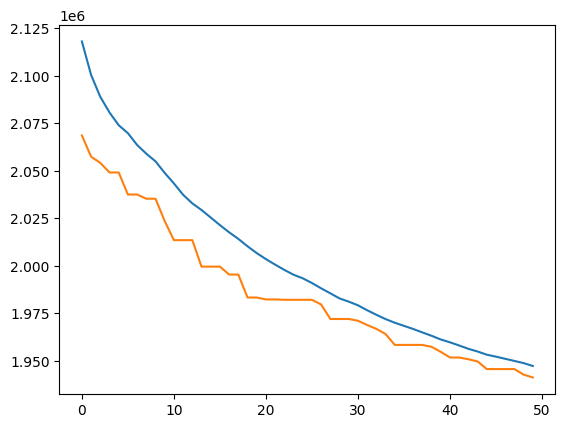

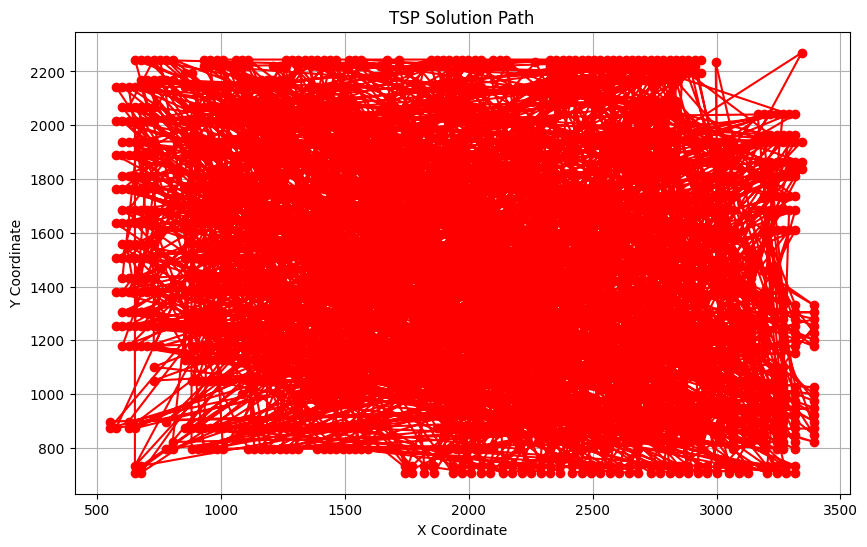

Best Distance for Map 1: 1941112.67
Execution Time for Map 1: 130.67 seconds
Running TSP Solver for Map 2...
Skipping invalid line: NAME : u2152
Skipping invalid line: COMMENT : Drilling problem (Reinelt)
Skipping invalid line: TYPE : TSP
Skipping invalid line: DIMENSION : 2152
Skipping invalid line: EDGE_WEIGHT_TYPE : EUC_2D


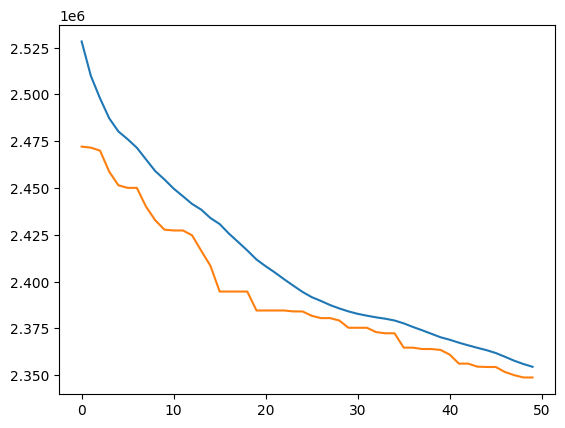

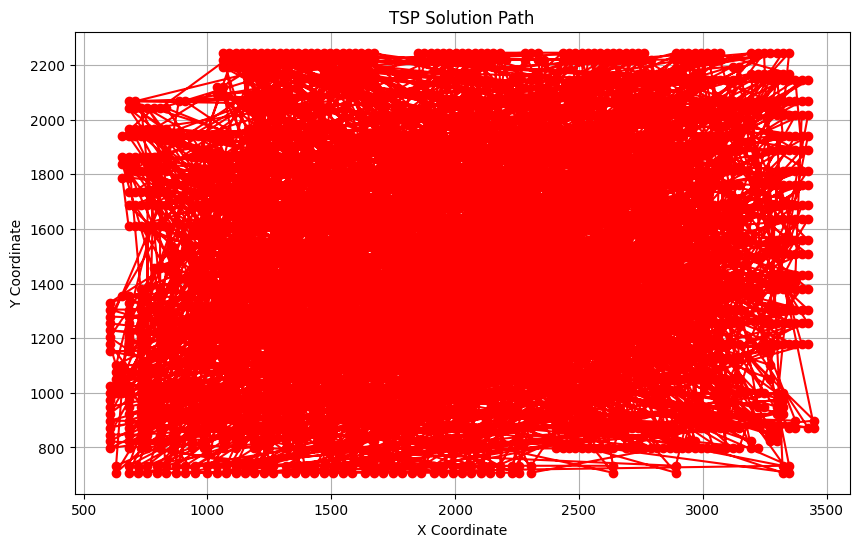

Best Distance for Map 2: 2348800.52
Execution Time for Map 2: 155.73 seconds


In [7]:
# Define the folder path where the files are stored
folder_path = "tsplib-master"

# Retrieve .tsp files and the .problems file
tsp_files, problems_file = load_files_from_folder(folder_path)

# Load the problem data from the .problems file
problem_data = load_problems_data(problems_file)

# Run the solver for each .tsp file
for idx, tsp_file in enumerate(tsp_files):
    print(f"Running TSP Solver for Map {idx + 1}...")
    
    # Create the map for this specific .tsp file
    map_ = Map.from_tsp_file(tsp_file)  # Corrected, passing the file path

    
    # Use configurations from the .problems file (if necessary)
    solver = TravelingSalesmanProblemSolver(map_=map_, generation_size=100, mutate_p=0.05, n_iter=50)
    
    # Evaluate performance
    means, bests, solution, execution_time = evaluate_performance(solver)
    
    # Optionally, visualize the final solution for each map
    map_.visualize(solution)
    
    # Print results
    print(f"Best Distance for Map {idx + 1}: {bests[-1]:.2f}")
    print(f"Execution Time for Map {idx + 1}: {execution_time:.2f} seconds")

